# Analysis for proportional-integral control

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 16})

In [33]:
def characterize(datapaths: list, set_pt_temp, band, overshoot=True):
    
    """
    datapaths is a list to the paths for the raw data for one set point temperature and one band
    
    set_pt_temp is the set point temperature (-10 or 45)
    
    band is the full band size (1, 3, 4.8 or 8)
    
    overshoot just picks if you want the last datapoint above or below the steady state. 
        Mess with this to see if you get better results if needed
    """
    
    # calculating stuff
    band = band/2
    
    ss = np.zeros(len(datapaths))
    stab = np.zeros(len(datapaths))
    rt = np.zeros(len(datapaths))
    
    plt.figure(figsize=(10,4))

    for i, path in enumerate(datapaths):
        data = np.genfromtxt(path, skip_header=13, delimiter=",")
        

        # calculate when it enters the band
        up = set_pt_temp+band
        start = np.where(abs(data[:,1]-up) == abs(data[:,1]-up).min())[0][0]
        
        
        # steady-state temperature
        ss[i] = np.mean(data[:,1][start:])

        # quantify stability
        stab[i] = np.std(data[:,1])**2#/np.sqrt(len(data[:,1]))

        start = np.where(abs(data[:,1]-up) == abs(data[:,1]-up).min())[0][0]
        plt.plot((data[start:,0]-data[0,0]), data[start:,1], ".")


    # calculate residual control error and steady state temp
    steady_state = np.mean(ss)
    print("Steady state temp:", steady_state, "+-", np.std(ss))
    residual_control_error = steady_state - set_pt_temp
    print("Residual control error:", residual_control_error, "+-", np.std(ss))

    # calculate system stability
    stability = np.mean(stab)
    print("Stability:", stability, "+-", np.std(stab))
    
    for i, path in enumerate(datapaths):
        
        data = np.genfromtxt(path, skip_header=13, delimiter=",")
        
        # calculate where it enters the band
        up = set_pt_temp+band
        start = np.where(abs(data[:,1]-up) == abs(data[:,1]-up).min())[0][0]
        
        # halfway point after it enters the band
        half = int(len(data[start:,1])/3) + start
        
        # calculate the last point where it's outside of the steady state +- resolution
        resolution = 0.03125
        if overshoot:
            end = np.where(data[start:half,1] > (steady_state + resolution))[0][-1]
        else: 
            end = np.where(data[start:half,1] < (steady_state + resolution))[0][-1]

        # calculate response time
        rt[i] = (data[:,0]-data[0,0])[start+end] - (data[:,0]-data[0,0])[start]
        
        # quantify stability from when it enters the band (high variance = bad stability)
        stab[i] = np.std(data[start:,1])**2
        

    # calculate response time
    response_time = np.mean(rt)
    print("Response time:", response_time, "+-", np.std(rt))
    
    plt.hlines(set_pt_temp+band, (data[start:,0]-data[0,0])[0], (data[:,0]-data[0,0])[start], linestyle="--", colors="gray")
    plt.hlines(steady_state, (data[start:,0]-data[0,0])[0], 280, linestyle="--", colors="gray")
    plt.vlines((data[:,0]-data[0,0])[start], set_pt_temp-band, set_pt_temp+band, colors="C3")
    plt.vlines((data[:,0]-data[0,0])[end+start], set_pt_temp, steady_state, colors="C3")
    plt.show()
    
    return {"rt" : response_time,
           "rt_err" : np.std(rt),
           "stab" : stability,
           "stab_err" : np.std(stab),
           "steady_state_temp" : steady_state,
           "steady_state_temp_err" : np.std(ss),
           "control_error" : residual_control_error,
           "control_error_err" : np.std(ss)}

Steady state temp: 44.8746463768116 +- 0.0
Residual control error: -0.1253536231884027 +- 0.0
Stability: 30.71935549229446 +- 0.0
Response time: 59.599999999999994 +- 0.0


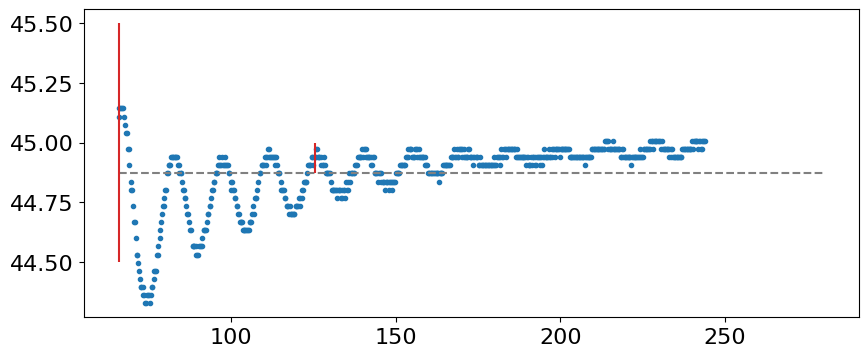

Steady state temp: 44.970346341463404 +- 0.0
Residual control error: -0.02965365853659563 +- 0.0
Stability: 41.209241498681855 +- 0.0
Response time: 1.8000000000000114 +- 0.0


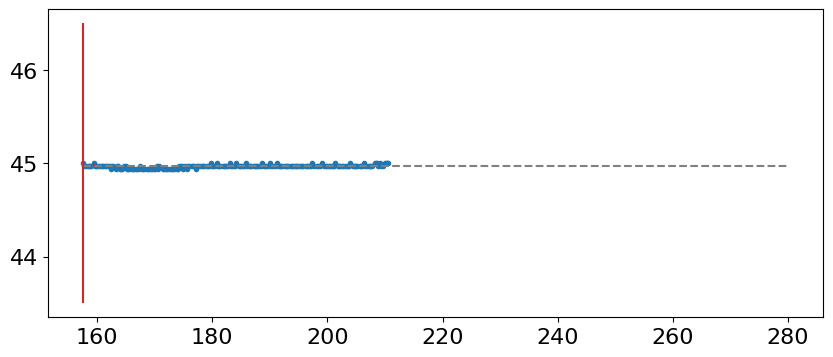

Steady state temp: 44.98271428571428 +- 0.0
Residual control error: -0.017285714285719678 +- 0.0
Stability: 16.01817891025234 +- 0.0
Response time: 5.199999999999989 +- 0.0


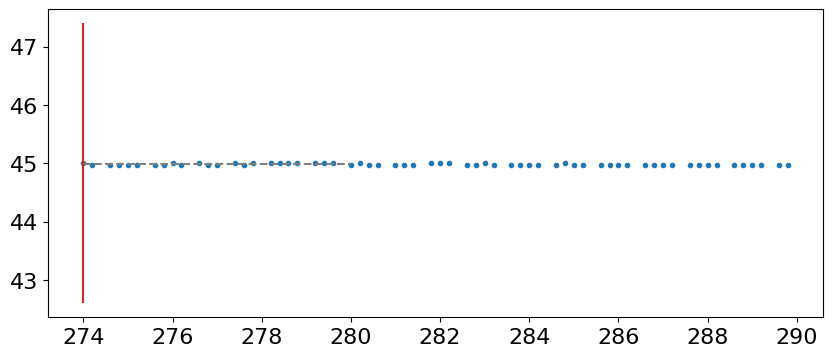

Steady state temp: 44.96772868217055 +- 0.0
Residual control error: -0.03227131782944781 +- 0.0
Stability: 20.081291475310344 +- 0.0
Response time: 8.0 +- 0.0


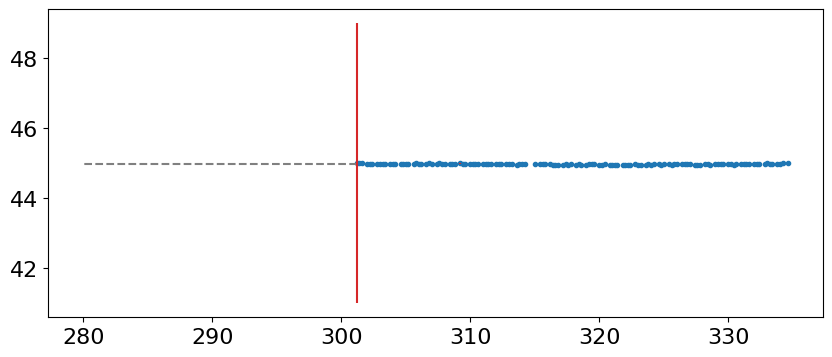

In [34]:
paths = ["../data/e4_1_45.raw"]
band_1 = characterize(paths, 45, 1)

paths = ["../data/e4_3_45.raw"]
band_3 = characterize(paths, 45, 3)

paths = ["../data/e4_4.8_45.raw"]
band_48 = characterize(paths, 45, 4.8, overshoot = False)

paths = ["../data/e4_8_45.raw"]
band_8 = characterize(paths, 45, 8)

274.0


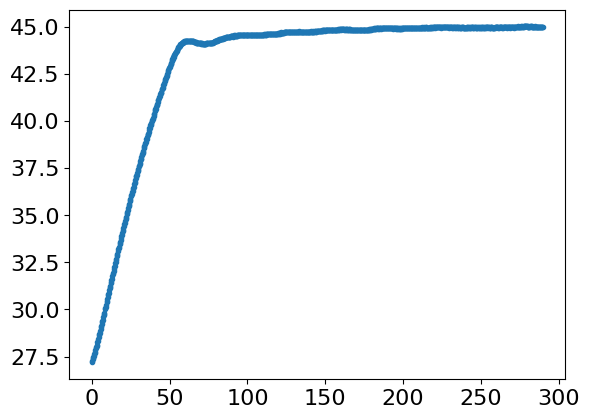

In [44]:
path = "../data/e4_4.8_45.raw"
data = np.genfromtxt(path, skip_header=13, delimiter=",")
set_pt_temp = 45
band = 1/2
up = set_pt_temp+band
start = np.where(abs(data[:,1]-up) == abs(data[:,1]-up).min())[0][0]
print((data[:,0]-data[0,0])[start])
plt.plot(data[:,0]-data[0,0], data[:,1], ".", color="tab:blue")

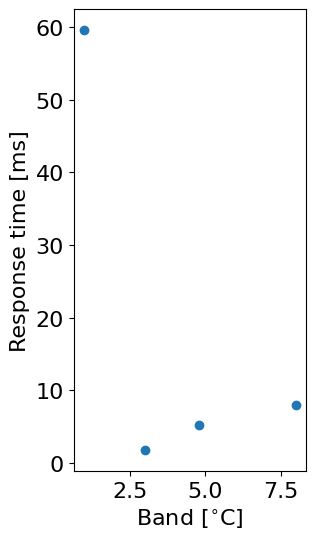

In [36]:
rt = [band_1["rt"], band_3["rt"], band_48["rt"], band_8["rt"]]
rt_err = [band_1["rt_err"], band_3["rt_err"], band_48["rt_err"], band_8["rt_err"]]

plt.figure(figsize=(3, 6))
plt.errorbar([1, 3, 4.8, 8], rt, rt_err, fmt="o", capsize=3)
plt.ylabel("Response time [ms]")
plt.xlabel("Band [$^{\circ}$C]")
plt.show()

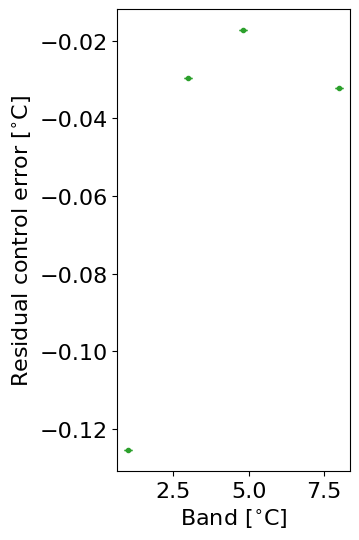

In [37]:
control_error = [band_1["control_error"], band_3["control_error"], band_48["control_error"], band_8["control_error"]]
control_error_err = [band_1["control_error_err"], band_3["control_error_err"], band_48["control_error_err"], band_8["control_error_err"]]

plt.figure(figsize=(3, 6))
plt.errorbar([1, 3, 4.8, 8], control_error, control_error_err, fmt="C2.", capsize=3)
plt.ylabel("Residual control error [$^{\circ}$C]")
plt.xlabel("Band [$^{\circ}$C]")
plt.show()

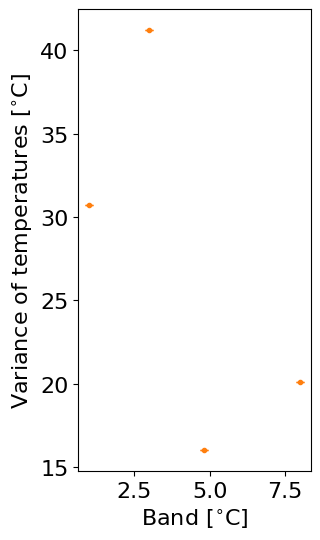

In [38]:
stab = [band_1["stab"], band_3["stab"], band_48["stab"], band_8["stab"]]
stab_err = [band_1["stab_err"], band_3["stab_err"], band_48["stab_err"], band_8["stab_err"]]

plt.figure(figsize=(3, 6))
plt.errorbar([1, 3, 4.8, 8], stab, stab_err, fmt="C1.", capsize=3)
plt.ylabel("Variance of temperatures [$^{\circ}$C]")
plt.xlabel("Band [$^{\circ}$C]")
plt.show()

Steady state temp: -9.854488616462346 +- 0.0
Residual control error: 0.14551138353765403 +- 0.0
Stability: 75.69851947967604 +- 0.0
Response time: 48.599999999999966 +- 0.0


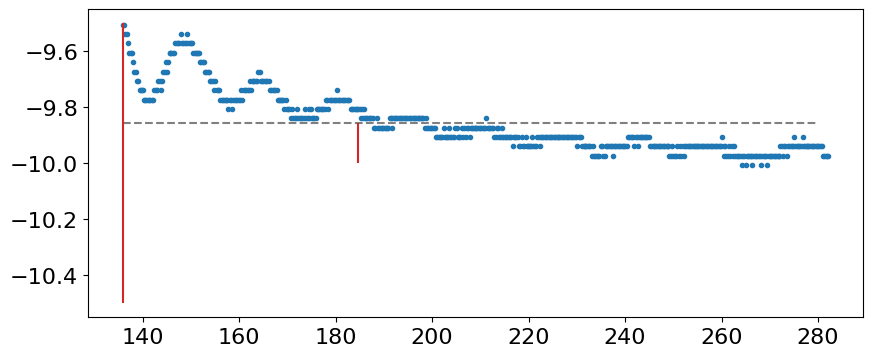

Steady state temp: -9.695451388888888 +- 0.0
Residual control error: 0.3045486111111124 +- 0.0
Stability: 58.22603541583539 +- 0.0
Response time: 66.80000000000001 +- 0.0


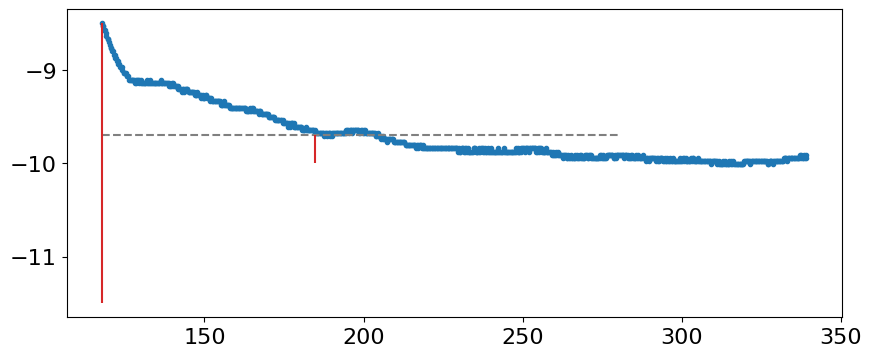

Steady state temp: -9.54586489361702 +- 0.0
Residual control error: 0.4541351063829797 +- 0.0
Stability: 64.4094344930613 +- 0.0
Response time: 76.80000000000001 +- 0.0


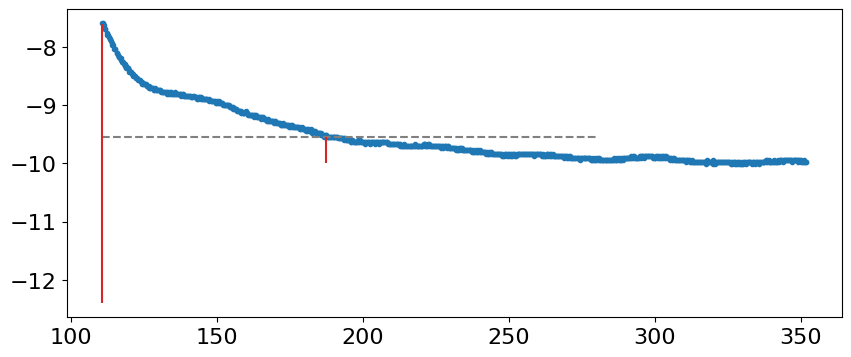

Steady state temp: -9.228173580786024 +- 0.0
Residual control error: 0.7718264192139763 +- 0.0
Stability: 59.57404522880616 +- 0.0
Response time: 78.00000000000001 +- 0.0


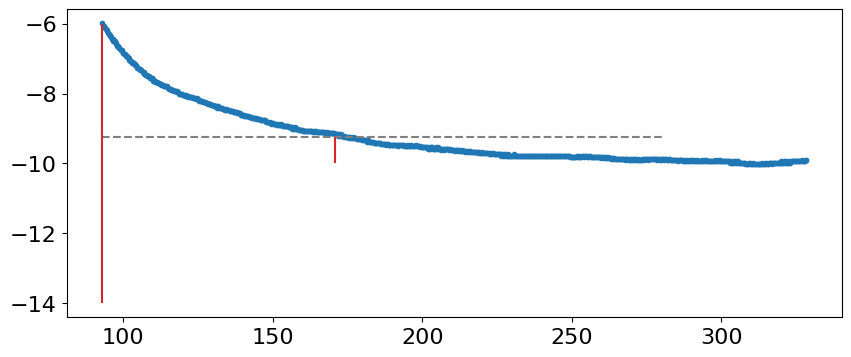

In [39]:
paths = ["../data/e4_1_-10.raw"]
band_1 = characterize(paths, -10, 1)

paths = ["../data/e4_3_-10.raw"]
band_3 = characterize(paths, -10, 3)

paths = ["../data/e4_4.8_-10.raw"]
band_48 = characterize(paths, -10, 4.8)

paths = ["../data/e4_8_-10.raw"]
band_8 = characterize(paths, -10, 8)

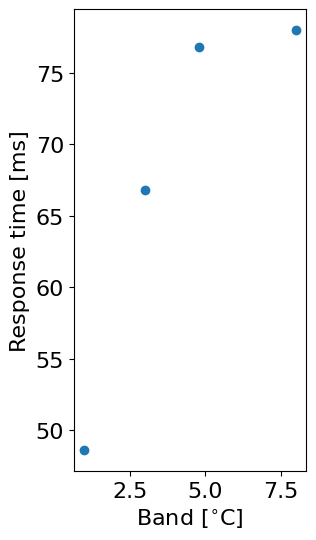

In [40]:
rt = [band_1["rt"], band_3["rt"], band_48["rt"], band_8["rt"]]
rt_err = [band_1["rt_err"], band_3["rt_err"], band_48["rt_err"], band_8["rt_err"]]

plt.figure(figsize=(3, 6))
plt.errorbar([1, 3, 4.8, 8], rt, rt_err, fmt="o", capsize=3)
plt.ylabel("Response time [ms]")
plt.xlabel("Band [$^{\circ}$C]")
plt.show()

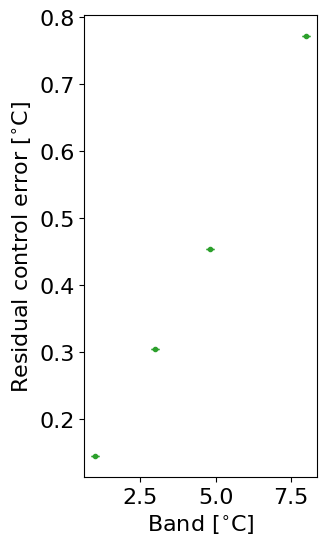

In [41]:
control_error = [band_1["control_error"], band_3["control_error"], band_48["control_error"], band_8["control_error"]]
control_error_err = [band_1["control_error_err"], band_3["control_error_err"], band_48["control_error_err"], band_8["control_error_err"]]

plt.figure(figsize=(3, 6))
plt.errorbar([1, 3, 4.8, 8], control_error, control_error_err, fmt="C2.", capsize=3)
plt.ylabel("Residual control error [$^{\circ}$C]")
plt.xlabel("Band [$^{\circ}$C]")
plt.show()

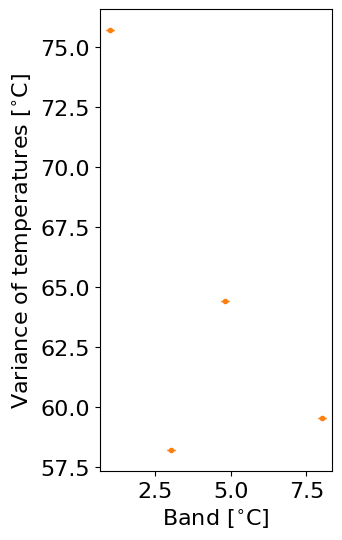

In [42]:
stab = [band_1["stab"], band_3["stab"], band_48["stab"], band_8["stab"]]
stab_err = [band_1["stab_err"], band_3["stab_err"], band_48["stab_err"], band_8["stab_err"]]

plt.figure(figsize=(3, 6))
plt.errorbar([1, 3, 4.8, 8], stab, stab_err, fmt="C1.", capsize=3)
plt.ylabel("Variance of temperatures [$^{\circ}$C]")
plt.xlabel("Band [$^{\circ}$C]")
plt.show()